## Scope of Variables

https://docs.julialang.org/en/v1/manual/variables-and-scoping/#scope-of-variables


The scope of a variable is the region of code within which a variable is visible. Variable scoping helps avoid variable naming conflicts.

There are two main types of scopes in Julia, global scope and local scope. The latter can be nested.

While we will not cover scope in full detail, some examples will be given so we get an intuitive sense of what is going on.

### Global Scope

* Each module introduces a new global scope, separate from the global scope of all other modules—there is no all-encompassing global scope. 
* Modules can introduce variables of other modules into their scope through the using or import statements or through qualified access using the dot-notation, i.e. each module is a so-called namespace as well as a first-class data structure associating names with values. 
*Note that while variable bindings can be read externally, they can only be changed within the module to which they belong

In [1]:
module A
    a = 1 # a global in A's scope
end;

In [3]:
a

UndefVarError: UndefVarError: a not defined

In [ ]:
#matplotlib.pyplot.plt

In [6]:
module B
module C
c = 2
end
b = C.c    # can access the namespace of a nested global scope
# through a qualified access
import ..A # makes module A available
d = A.a
end;

In [7]:
module D
    b = a # errors as D's global scope is separate from A's
end

UndefVarError: UndefVarError: a not defined

In [8]:
module E
    import ..A # makes A available
    A.a = 2 # error's as we cannot modify data in other modules.
end

ErrorException: cannot assign variables in other modules

## Local Scope

While there are specific rules in Julia for what the expressiosn means based on where the assignment expression occurs, we will only look at this intuitively. 

Compare the following examples

In [9]:
function hello()
    x = "hello world"
    println(x)
end

hello (generic function with 1 method)

In [10]:
hello()

hello world


In [11]:
x #global scope


UndefVarError: UndefVarError: x not defined

Inside of the `hello` function, the assignment `x = "hello world"` causes `x` to be a new local variable in the function's scope. Since `x` is local , it doesn't matter if there is a global named `x` or not. See what happens when we define `x=123` before defining and calling `hello`.

In [12]:
x = 123 # global

123

In [13]:
function hello()
    x = "hello world"
    println(x)
end

hello (generic function with 1 method)

In [14]:
hello()

hello world


In [15]:
x

123

Since the x in `hello` is local, the value (or lack thereof) of the global `x` is unaffected by calling `hello`.

In [16]:
function sum_to(n)
    s = 0 # new local
    for i = 1:n
        s = s + i # assign existing local
    end
    return s # same local
end

sum_to (generic function with 1 method)

In [17]:
sum_to(10)

55

In [18]:
s #global

UndefVarError: UndefVarError: s not defined

In [19]:
s = 0
for i = 1:10
    s += i
end

In [20]:
s

55

A `for` loop or comprehension iteration variable is always a new variable:

In [24]:
function f()
    i=0
    for i=1:3
        #empty
    end
    return i
end

f (generic function with 1 method)

In [26]:
# not return 3 because i was redirected after loop
f()

123

0

However, it is occasionally useful to reuse an existing local variable as the iteration variable. This can be done conveniently by adding the keyword `outer`:

In [27]:
function f()
    i=0
    for outer i=1:3
        #empty
    end
    return i
end

f (generic function with 1 method)

In [28]:
f()

3

In [29]:
i

UndefVarError: UndefVarError: i not defined

Finally, we can force local variables to be usable by the global scope, using the keyword `global` : 

In [30]:
function f()
    global i=0
    for outer i=1:3
        #empty
    end
    return i
end

f (generic function with 1 method)

In [31]:
i

UndefVarError: UndefVarError: i not defined

In [32]:
f()

3

In [33]:
i

3

## Constants
A common use of variables is giving names to specific, unchanging values. Such variables are only assigned once. This intent can be conveyed to the compiler using the `const` keyword:

In [34]:
const e  = 2.71828182845904523536;
const pi = 3.14159265358979323846;

Multiple variables can be declared in a single `const` statement:

In [35]:
const a, b = 1, 2

(1, 2)

In [41]:
const x = 1.0

ErrorException: cannot declare x constant; it already has a value

In [45]:
x

1

If a new value has a different type than the type of the constant then an error is thrown:

In [42]:
x=1

1

If a new value has the same type as the constant then a warning is printed:

In [43]:
const y = 1.0


1.0

In [44]:
y = 2.0

2.0

### Performance tip : 
The const declaration should only be used in global scope on globals. It is difficult for the compiler to optimize code involving global variables, since their values (or even their types) might change at almost any time. If a global variable will not change, adding a `const` declaration solves this performance problem.

## Benchmarking tips

In the `Julia is fast` notebook, we saw the package `BenchmarkTools` and used its `@benchmark` macro.

In this notebook, we'll explore the importance of "interpolating" global variables when benchmarking functions.

We interpolate a global variable by throwing a `$` in front of it. For example, in `Julia is fast`, we benchmarked the `sum` function using `Vector` `A` via

```julia
@benchmark sum($A)
```

not

```julia
@benchmark sum(A)
```

> If the expression you want to benchmark depends on external variables, you should use $ to "interpolate" them into the benchmark expression to avoid the problems of benchmarking with globals. Essentially, any interpolated variable \$x or expression \$(...) is "pre-computed" before benchmarking begins:

[source](https://github.com/JuliaCI/BenchmarkTools.jl#quick-start)

Let's see if this can make a difference by examining the ratio in execution times of `sum($A)` and `sum(A)` for differently sized arrays `A`. 

#### Exercise

Call the `sum` function on a pseudo-randomly populated 1D array called `foo` of several lengths between 2 and 2^20 (~10^6). For each size of `foo`, determine the ratio of execution times for `sum(foo)` and `sum($foo)`. (To determine this ratio, use the minimum run times in each case.)

Plot the ratio of execution times for non-interpolated and interpolated `foo` in calls to `sum` versus the length of `foo`. Does interpolating `foo` seem to matter? If so, for what sizes of `foo`?

In [46]:
using BenchmarkTools, Plots
gr()

Plots.GRBackend()

In [48]:
store_ratios = []
foo = rand()
for i in 1 : 20
	foo = rand(2 ^ i)
	not_interpolated = @benchmark sum(foo)
	interpolated = @benchmark sum($foo)
	min_not_interpolated = minimum(not_interpolated.times)
	min_interpolated = minimum(interpolated.times)
	ratio = min_not_interpolated / min_interpolated
	append!(store_ratios, ratio)
end


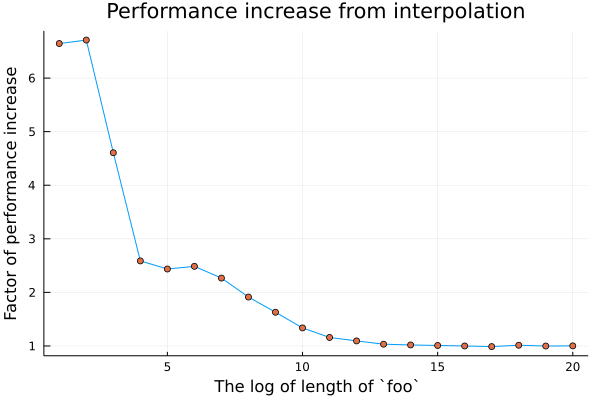

In [49]:
plot([i for i in 1 : 20], store_ratios, legend = false)
scatter!([i for i in 1 : 20], store_ratios)
xlabel!("The log of length of `foo`")
ylabel!("Factor of performance increase")
title!("Performance increase from interpolation")

## Performance tips -- type stability

One way to optimize code in Julia is to ensure **type stability**. If the type(s) of some variables in a function are subject to change or ambiguity, the compiler cannot reason as well about those variables, and performance will take a hit. Conversely, we allow the compiler to optimize and generate more efficient machine code when we declare variables so that their types will be fixed throughout the function body.

For example, let's say we had functions called `baz` and `bar` with the following definitions

```julia
function baz()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return 1//3    
    else
        return 0    
    end
end
```

```julia
function bar()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return .3333333    
    else
        return 0.0    
    end
end
```

When I benchmark these via

```julia
using BenchmarkTools
@benchmark baz()
@benchmark bar()
```

I see that `bar` is almost three times as fast as `baz`! The reason is that `bar` is type stable while `baz` is not: the compiler can tell that `bar` will always return a `Float`, whereas `baz` could return a `Float`, an `Int`, or a `Rational`. When the compiler can tell what the types of outputs from a function, or variables declared *within a function* are without running the code, it can do much better.

#### Exercise

The following definition for `my_sum` is not type stable. 

```julia
function my_sum(A)
    output = 0
    for x in A
        output += x
    end
    return output
end
```

Copy and execute the above code into a new cell. Benchmark it using `A = rand(10^3)`. Then write a new function called `my_sum2` with the same function body as `my_sum`. Update `my_sum2` to make it type stable, and benchmark it for a randomly populated array with 10^3 entries.

How much does type stability impact performance? If you'd like, try this same exercise for multiple sizes of `A` to see if this changes your answer!

* Hint : Try checking the type of A



In [50]:
function baz()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return 1//3    
    else
        return 0    
    end
end

baz (generic function with 1 method)

In [51]:
function bar()
    s = rand()
    if s > 2/3
        return .666667
    elseif s > 1/3
        return .3333333    
    else
        return 0.0    
    end
end

bar (generic function with 1 method)

In [52]:
using BenchmarkTools


In [53]:
@benchmark baz()


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.450 ns (0.00% GC)
  median time:      11.221 ns (0.00% GC)
  mean time:        11.252 ns (0.00% GC)
  maximum time:     18.849 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999

In [54]:
@benchmark bar()

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     2.210 ns (0.00% GC)
  median time:      2.410 ns (0.00% GC)
  mean time:        2.379 ns (0.00% GC)
  maximum time:     9.970 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [55]:
function my_sum(A)
    output = 0
    for x in A
        output += x
    end
    return output
end

my_sum (generic function with 1 method)

In [68]:
A_e = rand(10^3);

In [69]:
@benchmark my_sum($A_e)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     627.267 ns (0.00% GC)
  median time:      630.703 ns (0.00% GC)
  mean time:        631.134 ns (0.00% GC)
  maximum time:     712.157 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     172

In [70]:
function my_sum2(A)
	output = zero(eltype(A))
    for x in A
        output += x
    end
    return output
end

my_sum2 (generic function with 1 method)

In [71]:
@benchmark my_sum2($A_e)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     627.251 ns (0.00% GC)
  median time:      631.292 ns (0.00% GC)
  mean time:        632.828 ns (0.00% GC)
  maximum time:     724.684 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     171

#### Exercise

Make the following code type stable. You'll know your efforts are paying off when you see a performance boost!

```julia
"""
    my_sqrt(x)
    
Calculate the square root of `x` with Newton's method.
"""
function my_sqrt(x)
    output = 1
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end
```

In [72]:
function my_sqrt(x)
    output = 1
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt (generic function with 1 method)

In [73]:
@benchmark my_sqrt(100)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.056 μs (0.00% GC)
  median time:      4.100 μs (0.00% GC)
  mean time:        4.115 μs (0.00% GC)
  maximum time:     6.836 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [74]:
function my_sqrt2(x)
    output = 1.0
    for i in 1:1000
        output = .5 * (output + x/output)
    end
    output
end

my_sqrt2 (generic function with 1 method)

In [75]:
@benchmark my_sqrt2(100)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.984 μs (0.00% GC)
  median time:      4.119 μs (0.00% GC)
  mean time:        4.135 μs (0.00% GC)
  maximum time:     5.479 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     7